© 2025. Triad National Security, LLC. All rights reserved.
This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S. Department of Energy/National Nuclear Security Administration. All rights in the program are reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear Security Administration. The Government is granted for itself and others acting on its behalf a nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare. derivative works, distribute copies to the public, perform publicly and display publicly, and to permit others to do so.


"""
Analytic solution for H.A. Lauweier "The transport of heat in an oil layer caused by the injection of hot fluid" (1955). Thermo-Hydro coupled solution

Injection of water at a constant rate into a single fracture in thermally active impermeable matrix. Fracture aperature is fixed.
"""

In [1]:
%pip install numpy matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.special import erfc
%matplotlib inline

In [39]:
def fracture_temperature(xi, theta, tau, T_inject, T0):
    """ Analytic solution for pressure

    Parameters
    -------------------
        xi : numpy array 
            dimensionless length
        theta : float
            ratio of specific heat of water and surrounding rock
        tau : float
            dimensionless time
        T_inject : float
            injection temperature
        T0 : float
            initial rock temperature

    Returns 
    -----------------
        temperature : numpy array
            temperature solution 

    Notes
    -----------------
        None
    
    """
    print("Computing Temperature (Lauwerier)")
    T_relative = T_inject - T0
    
    # Prepare argument for erfc only where (τ - ξ) > 0:
    #   argument = ξ / (2√[θ(τ - ξ)])
    # If τ <= ξ, set the result to T0.
    arg = xi / (2 * np.sqrt(theta * (tau - xi)))
    temperature = np.where(
        tau > xi,
        T_relative * erfc(arg) + T0,
        T0
    )
    return temperature

In [40]:


def matrix_temperature(xi, theta, tau, eta, T_inject, T0):
    """ Analytic solution for pressure

    Parameters
    -------------------
        xi : numpy array 
            dimensionless length
        theta : float
            ratio of specific heat of water and surrounding rock
        tau : float
            dimensionless time
        T_inject : float
            injection temperature
        T0 : float
            initial rock temperature

    Returns 
    -----------------
        temperature : numpy array
            temperature solution 

    Notes
    -----------------
        None
    
    """
    print("Computing Temperature (Lauwerier)")
    T_relative = T_inject - T0

    # Compute |η| and clamp anything inside (-1,1) to exactly 1
    eta_eff = np.where(np.abs(eta) < 1, 1.0, np.abs(eta))

    # Turn xi into shape (Nx, 1) and eta_eff into (1, Nz) so we get an (Nx x Nz) matrix
    ξ2d = xi[:, np.newaxis]
    η2d = eta_eff[np.newaxis, :]

    # Denominator 2*sqrt[ θ * (τ - ξ) ] – this must be positive, so mask out τ <= ξ
    denom = 2 * np.sqrt(theta * (tau - ξ2d))
    arg_matrix = (ξ2d + η2d - 1) / denom

    # Now mask: only compute erfc where (τ - ξ) > 0; otherwise result is T0
    mask = (tau > ξ2d)
    temperature = np.where(
        mask,
        T_relative * erfc(arg_matrix) + T0,
        T0
    )

    return temperature

In [41]:
rho_r = 2757        # kg/m^3
rho_w = 1000        # kg/m^3
c_r   = 1180        # J/kg/K
c_w   = 4184        # J/kg/K
b     = 1e-3        # m (fracture aperture)
k_r   = 0.5         # W/m/K (rock conductivity)
v_w   = 0.4025/100  # m/s (water velocity in fracture)

Lx = 100.0
dx = 1.0
Nx = int(np.ceil(Lx/dx))
x_a = np.linspace(dx, Lx, Nx)

Lz = 100.0
dz = 1.0
Nz = int(np.ceil(Lz/dz))
z_a = np.linspace(-Lz/2, Lz/2, Nz)

# dimensionless variables
xi     = (k_r / ((b/2)**2 * rho_w * c_w * v_w)) * x_a
theta  = (rho_w * c_w) / (rho_r * c_r)
eta    = z_a / (b/2)

year    = 365 * 24 * 3600
times   = [1*year, 5*year, 10*year]
taus    = [(k_r / ((b/2)**2 * rho_w * c_w)) * t for t in times]

T_inject = 90  # degC
T0       = 20  # degC (initial rock temp)

fracture_temperature_analytic = [fracture_temperature(xi, theta, tau, T_inject, T0) for tau in taus]
matrix_temperature_analytic = [matrix_temperature(xi, theta, tau, eta, T_inject, T0)   for tau in taus]


Computing Temperature (Lauwerier)
Computing Temperature (Lauwerier)
Computing Temperature (Lauwerier)
Computing Temperature (Lauwerier)
Computing Temperature (Lauwerier)
Computing Temperature (Lauwerier)


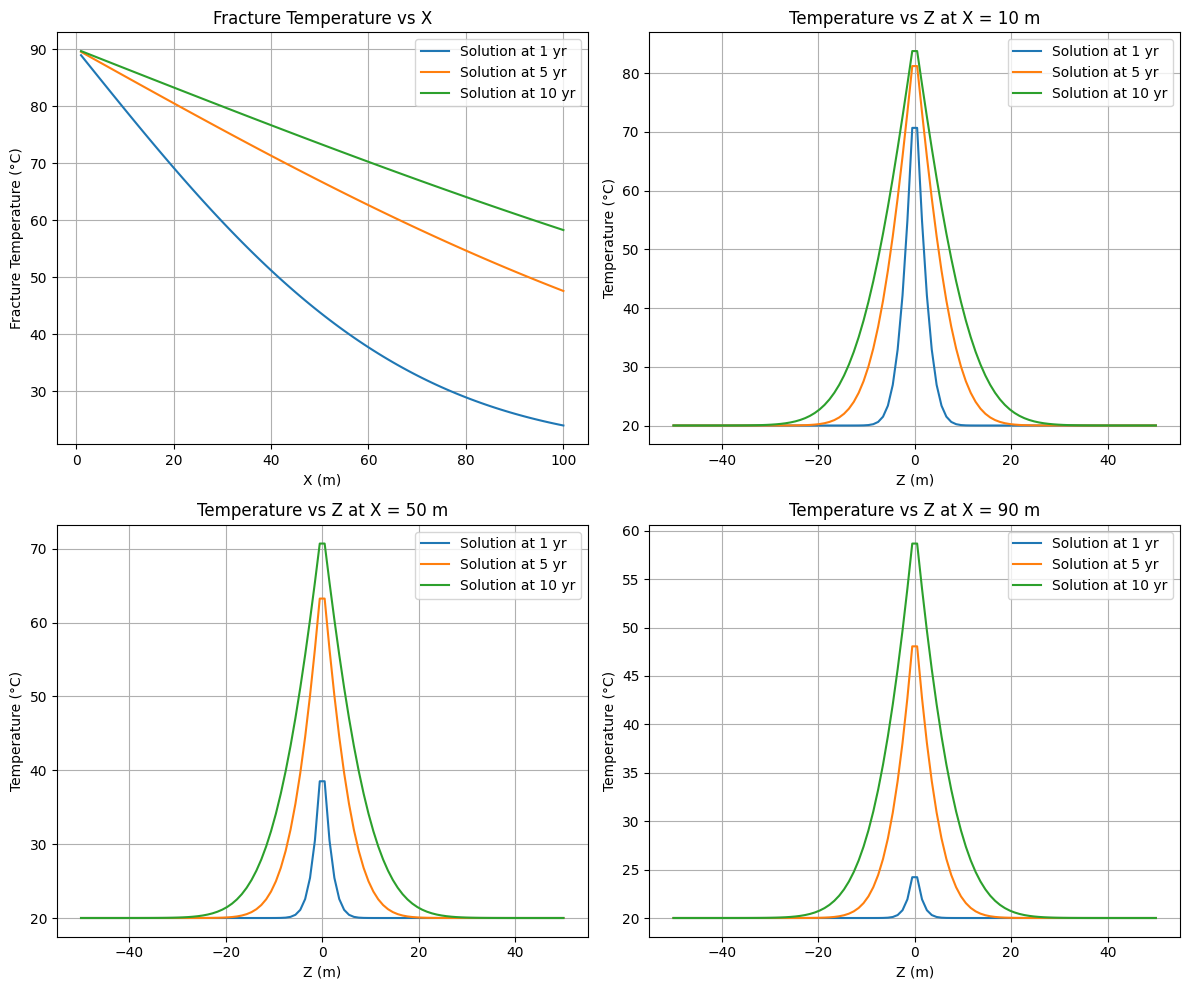

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['1 yr', '5 yr', '10 yr']

# ┌── Top‐Left: Tf(x) ─────────────────────────────────────────────────────────
ax = axes[0,0]
for Tf, c, lbl in zip(fracture_temperature_analytic, colors, labels):
    ax.plot(x_a, Tf, color=c, label=f"Solution at {lbl}")
ax.set_xlabel("X (m)")
ax.set_ylabel("Fracture Temperature (°C)")
ax.set_title("Fracture Temperature vs X")
ax.grid(True)
ax.legend()

# ┌── Top‐Right: T(z) at X = 10 m ────────────────────────────────────────────
ax = axes[0,1]
idx_10 = np.argmin(np.abs(x_a - 10.0))
for Tm, c, lbl in zip(matrix_temperature_analytic, colors, labels):
    ax.plot(z_a, Tm[idx_10, :], color=c, label=f"Solution at {lbl}")
ax.set_xlabel("Z (m)")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Temperature vs Z at X = 10 m")
ax.grid(True)
ax.legend()

# ┌── Bottom‐Left: T(z) at X = 50 m ─────────────────────────────────────────
ax = axes[1,0]
idx_50 = np.argmin(np.abs(x_a - 50.0))
for Tm, c, lbl in zip(matrix_temperature_analytic, colors, labels):
    ax.plot(z_a, Tm[idx_50, :], color=c, label=f"Solution at {lbl}")
ax.set_xlabel("Z (m)")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Temperature vs Z at X = 50 m")
ax.grid(True)
ax.legend()

# ┌── Bottom‐Right: T(z) at X = 90 m ─────────────────────────────────────────
ax = axes[1,1]
idx_90 = np.argmin(np.abs(x_a - 90.0))
for Tm, c, lbl in zip(matrix_temperature_analytic, colors, labels):
    ax.plot(z_a, Tm[idx_90, :], color=c, label=f"Solution at {lbl}")
ax.set_xlabel("Z (m)")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Temperature vs Z at X = 90 m")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()